## Import all required tools

In [1]:
import ixmp
import message_ix
import numpy as np
import pandas as pd
import yaml

from collections.abc import Mapping
from itertools import repeat
from message_ix.models import MESSAGE_ITEMS
from message_ix.utils import make_df
from message_ix.tools.add_dac import *

%matplotlib inline


mp = ixmp.Platform()


<IPython.core.display.Javascript object>

C:\Users\pratama\Documents\GitHub\MESSAGEix\message_ix\message_ix\reporting\__init__.py:98: FutureWarning: Importing from genno.computations will be deprecated in a future version; use genno.operator instead.
  ("tom:nl-t-yv-ya", (genno.computations.add, "fom:nl-t-yv-ya", "vom:nl-t-yv-ya")),


In [3]:
SLIST = mp.scenario_list()

In [10]:
SLIST.to_excel('scenarios.xlsx')


## Clone baseline and create emission bound scenario

In [11]:
# this is to import scenario from data base and clone to local
#base = message_ix.Scenario(mp, model='GENIE_sandbox', scenario="baselineYWP")
base = message_ix.Scenario(mp, model='ENGAGE_SSP2_v4.1.7', scenario="NPi2020_Prime")
scen = base.clone(
    "GENIE_sandbox",
    "daccs1000_paper_repro",
    "adding daccs and mission bound to baseline scenario",
    keep_solution=False, 
)
scen.check_out()

year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")


In [12]:
# add daccs
filepath = 'C:/Users/pratama/Documents/GitHub/MESSAGEix/message_ix/tutorial/dac_scenarios/data/tech_data.yaml'
add_dac(scen,filepath=filepath)

#### Add emission bound

In [13]:
# add emission bound
scen.add_par('bound_emission', ['World', 'TCE_CO2', 'all', 'cumulative'], value=2421.17, unit="tC")

## Run the model

In [14]:
scen.commit(comment="DACs scenario with emission bound")
scen.set_as_default()
scen.solve(solve_options={'barcrossalg': '2','scaind':'1'})
scen.var("OBJ")["lvl"]

3254907.5

In [38]:
#groups = {'DACs': ['dac_1','dac_2','dac_3','dac_4','dac_5']}
groups = {'DACs': ['dac_1_exports','dac_2_exports','dac_3_exports','dac_4_exports','dac_5_exports']}

def get_values(scenario,
               variable = '', valuetype = 'lvl',
               #filters = {}
              ): 
    # filters must use 'cat_tec' to aggregate technology
    # don't forget to include check unit
    """
    Parameters
    ----------
    scenario    : message_ix.Scenario()
        MESSAGEix Scenario where the data will be included
    variable    : string
        name of variable to report
    valuetype   : string, 'lvl' or 'mrg'
        type of values reported to report,
        either level or marginal.
        default is 'lvl'
    """
    
    if isinstance(scenario.var(variable), pd.DataFrame):
        df = scenario.var(variable)
        dimensions = [col for col in df.columns if col not in ['lvl','mrg']]
        return df.set_index(dimensions)[[valuetype]]
    else:
        return scenario.var(variable)[valuetype]

def get_report(scenario,
               technologies = '',
              ): 
    """
    Parameters
    ----------
    scenario    : message_ix.Scenario()
        MESSAGEix Scenario where the data will be included
    technologies    : string or list 
        name of technology to be reported
    variable    : string or list
        name of variable to report
    """
    var_dict  = {var: [] for var in ['CAP','CAP_NEW','INVESTMENT','REMOVAL']}
    
    # listing model years to be reported
    years_rep = (sorted(scenario.set('cat_year')
                        .set_index('type_year')
                        .loc['cumulative','year'].to_list()))
    
    # Create dataframe
    for var in var_dict.keys():
        # primary variables
        if var in ['CAP','CAP_NEW']:
            df = (get_values(scenario,var)['lvl'].unstack()
                  .loc[:,groups.get(technologies),:]
                  .groupby(['node_loc']).sum()
                 )[years_rep]
            
        # investment
        elif var == 'INVESTMENT':
            depl = (get_values(scenario,'CAP_NEW')['lvl'].unstack()
                   .loc[:,groups.get(technologies),:]
                   )[years_rep]
            
            dfic = scen.par('inv_cost')
            
            inv  = (dfic.loc[dfic['technology'].isin(groups.get(technologies))]
                    .set_index(['node_loc','technology','year_vtg'])['value'].unstack())
            
            df = depl.mul(inv).groupby(['node_loc']).sum()
        
        # removal
        elif var == 'REMOVAL':
            acts = get_values(scenario,'ACT').droplevel(['mode','time'])
            df   = acts.loc[:,groups.get(technologies),:,:]['lvl'].unstack().groupby(['node_loc']).sum()
            
        df.loc['World'] = df.sum(axis=0)
        
        var_dict[var] = df

    # Create dictionary for variable dataframes and write variables to excel
    with pd.ExcelWriter('get_report_output.xlsx', engine='openpyxl') as writer:
        for var in var_dict.keys():
            var_dict[var].to_excel(writer, sheet_name=var)
    
    return var_dict

        




In [16]:
dac_report = get_report(scen,'DACs')

In [18]:
dac_report['CAP']

year_act,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2070,2080,2090,2100,2110
node_loc,,,,,,,,,,,,,,,
R11_AFR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
R11_CPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,85.438642,1080.843768,1767.089480,2208.752176,1346.567097
R11_EEU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
R11_FSU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
R11_LAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.384402,36.64629,66.351946,433.618944,947.402347,720.932247,572.122703,342.550996
R11_MEA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,447.361086,447.361086,267.851607,160.372651,138.287119
R11_NAM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1042.753026
R11_PAO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,304.115032
R11_PAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


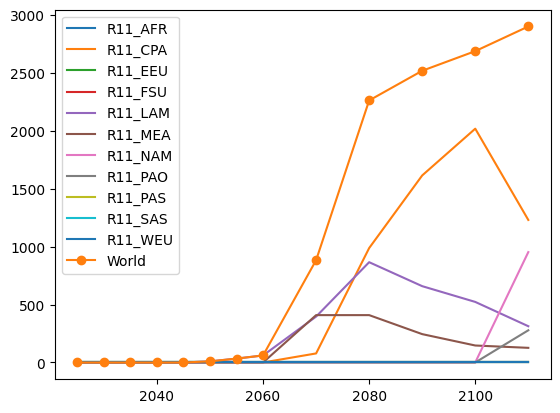

In [30]:
import matplotlib.pyplot as plt

var = 'REMOVAL'
for reg in range(len(dac_report[var])):
    kwargs = {'marker':'o'} if reg == 11 else {}
    plt.plot(dac_report[var].columns,dac_report[var].iloc[reg],label=dac_report[var].index[reg], **kwargs)
plt.legend()
plt.show()

In [31]:
benchmark_scen = message_ix.Scenario(mp, model='GENIE_SSP2_v4.1.7', scenario="EN_NPi2020-DACm-MP-median-stor3-final_1000")

This Scenario has a solution, use `Scenario.remove_solution()` or `Scenario.clone(..., keep_solution=False)`


In [39]:
groups = {'DACs': ['dac_1_exports','dac_2_exports','dac_3_exports','dac_4_exports','dac_5_exports']}
benchmark_report = get_report(benchmark_scen,'DACs')

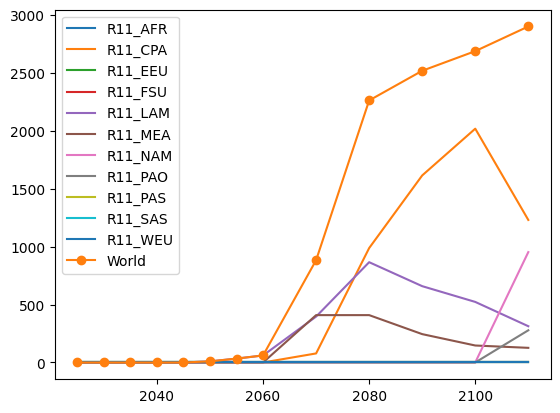

In [40]:
import matplotlib.pyplot as plt

var = 'REMOVAL'
for reg in range(len(dac_report[var])):
    kwargs = {'marker':'o'} if reg == 11 else {}
    plt.plot(dac_report[var].columns,dac_report[var].iloc[reg],label=dac_report[var].index[reg], **kwargs)
plt.legend()
plt.show()

## Close connection

In [41]:
mp.close_db()